# Parallelizing RNNs with the ungulates: DEER, quasi-DEER, ELK, and quasi-ELK

## A blog post based on "Towards Scalable and Stable Parallelization of nonlinear RNNs"

By Xavier Gonzalez, Andrew Warrington, Jimmy T.H. Smith, and Scott W. Linderman

**Parallelized computation has enabled the deep learning revolution.** In sequence modeling, transformers and deep SSMs (linear RNNs) have become dominant, in part because they can be parallelized over the sequence length, allowing them set modern parallelized hardware (GPUs/TPUs) to work on long sequences. In contrast, it was thought that evaluating nonlinear RNNs was inherently sequential.

**But nonlinear RNNs can be parallelized too!!** In this blog post, we are going to show you how!

In particular, we show how the DEER algorithm ([Lim et al., ICLR 2024](https://arxiv.org/abs/2309.12252)), as well as our extensions quasi-DEER, ELK, and quasi-ELK([Gonzalez et al., NeurIPS 2024](https://arxiv.org/abs/2407.19115)), can be used to accelerate the evaluation of RNNs on GPU by *parallelizing* their evaluation over the sequence length.

We demonstrate how to do so using the [ELK codebase](https://github.com/lindermanlab/elk), which builds on the [DEER codebase](https://github.com/machine-discovery/deer).

We fondly call these parallel algorithms for evaluating nonlinear dynamics ["the ungulates"](https://en.wikipedia.org/wiki/Ungulate) (large mammals with hooves). At their core, the different ungulates are different variants of [Newton's method](https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm). The below diagram shows how the ungulates relate to each other.

![Banner Schematic](https://raw.githubusercontent.com/lindermanlab/elk/refs/heads/main/ims/banner_with_citation.png)

## TLDR

### Math

* Parallelizing nonlinear dynamics is a simple as iterating the following two step procedure (DEER)
  1. Linearize the dynamics
  2. Evaluate the linearized dynamics in parallel using a parallel associative scan
* This simple approach turns out to be Newton's method (root finding) for the one step prediction error!
* DEER enjoys a global convergence guarantee (Proposition 1 of our paper), and so do more computation and memory efficient versions like **quasi-DEER**
  * quasi-DEER just involves taking the diagonal of the linearized dynamics.
* When the linearized dynamics are unstable, DEER and quasi-DEER can take a long time to converge. Stabilizing them with a trust region can accelerate convergence, and such a procedure can be implemented with a Kalman filter, which can also be parallelized. We call this approach **ELK**, for "**E**valuating **L**evenberg-Marquardt with **K**alman." ELK also comes in the more efficient quasi-ELK version.
* The Kalman filter is stabilizing the linear recursion by attenuating the eigenvalues of the dynamics (See Appendix A.3 of our paper).

### Code

* Using (quasi-)DEER is as simple as `from elk.algs.deer import seq1d`
* Using (quasi-)ELK is a simple as `from elk.algs.elk import elk`

Check out our demos below. And let parallelized RNNs rip in your own work!

## Installing the ELK codebase

Make sure to request a T4 GPU on colab!

In [ ]:
!git clone https://github.com/lindermanlab/elk.git

Cloning into 'elk'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 83 (delta 17), reused 22 (delta 10), pack-reused 46 (from 1)
Receiving objects: 100% (83/83), 99.44 MiB | 16.67 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
cd /content/elk

/content/elk


In [ ]:
! pip install --upgrade --no-deps -e .[flex]
! pip install -qqq equinox dynamax

Obtaining file:///content/elk
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for elk (pyproject.toml) ... done
  Created wheel for elk: filename=elk-0.1-0.editable-py3-none-any.whl size=3786 sha256=3f0c244274176723af43371e73fa71446a4390dac162f7f83a64f40f40c03762
  Stored in directory: /tmp/pip-ephem-wheel-cache-0h4mv296/wheels/a0/3a/c2/434f8e2f18e931f2b4ac0dda7518298eaac5cb424648432122
Successfully built elk
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conf

In [ ]:
import equinox as eqx
import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import warnings

from jax import lax
from jaxtyping import Float, Array
from functools import partial

warnings.filterwarnings('ignore')

In [ ]:
# @title Plotting set up


# Configure font sizes.
SMALL_SIZE = 7 + 1
MEDIUM_SIZE = 8 + 1
BIGGER_SIZE = 10 + 1
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Configure the line styles, colors etc.
cols = {
    "Sequential": "tab:green",
    "DEER": "tab:red",
    "Quasi-DEER": "tab:orange",
    "ELK": "tab:blue",
    "Quasi-ELK": "tab:purple",
}
lins = {"Sequential": ":", "DEER": "-", "Quasi-DEER": "-", "ELK": "-", "Quasi-ELK": "-"}
mars = {"Sequential": ".", "DEER": "+", "Quasi-DEER": "x", "ELK": "+", "Quasi-ELK": "x"}
tgs = {
    "Sequential": "seq",
    "DEER": "deer",
    "Quasi-DEER": "quasi",
    "ELK": "elk",
    "Quasi-ELK": "qelk",
}
labs = ["Sequential", "DEER", "Quasi-DEER", "ELK", "Quasi-ELK"]

## DEER: Parallel evaluation of nonlinear dynamics using Newton's method

Consider any nonlinear dynamical system with initial state $s_0 \in \mathbb{R}^D$ and which follows temporal evolution
$$
  s_t^* = f_t(s_{t-1}^*),
$$
where $f_t$ is a nonlinear dynamics function.

We could always unroll the trajectory $s^*_{1:T}$ from initial condition $s_0$ sequentially, but this is exactly the type of sequential computation that we want to move on from.

---

Instead, let's see we if we can process the entire sequence $s_{1:T}$ in parallel, starting from an initial guess $s^{(0)}_{1:T}$.

Define the **residual** of a particular guess $s_{1:T}$ as
\begin{align}
r(s)
&= [s_1 - f_1(s_0), \, s_2 - f_2(s_1), \ldots, s_T - f_T(s_{T-1})].
\end{align}
Note that this residual is basically the "one step prediction error" for some candidate trajectory $s_{1:T}$.

The only root of $r(s)$ is the true trajectory $s_{1:T}^{*}$. Thus, **we have changed the problem of evalauting a nonlinear dynamical system like an RNN into a problem in root-finding for a nonlinear equation**, $r(s)=0$. The first approach to consider for root-finding in a nonlinear equation is Newton's method!

Thus, the DEER algorithm is: **solve for the root using Newton's method, use a parallel solver for each Newton update.** The DEER algorithm iteratively finds the true trajectory $s^{*}_{1:T}$, starting from some initial guess $s^{(0)}_{1:T}$, and each iteration involves parallel computation over the entire sequence length.

The Newton update for solving the nonlinear equation $r(s) = 0$ for $s$ is,
\begin{align*}
s_{1:T}^{(i+1)}  &\leftarrow s_{1:T}^{(i)} - J(s_{1:T}^{(i)})^{-1} r(s_{1:T}^{(i)}),
\end{align*}
where $J(s_{1:T}^{(i)})$ is the $\mathbb{R}^{TD \times TD}$ Jacobian matrix given by
$$
    J(s_{1:T}^{(i)}) := \begin{pmatrix}
        I_D & 0 & 0 & \cdots & 0 & 0\\
        -\frac{\partial f_2}{\partial s}(s_{1}^{(i)}) & I_D & 0 & \cdots & 0 & 0\\
         0 & -\frac{\partial f_3}{\partial s}(s_{2}^{(i)}) & I_D & \cdots & 0 & 0\\
        \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
        0 & 0 & 0 & \cdots & I_D & 0 \\
        0 & 0 & 0 & \cdots & -\frac{\partial f_T}{\partial s} (s_{T-1}^{(i)}) & I_D \\
    \end{pmatrix}.
$$

This system can be solved with forward substitution, yielding the recursion,
\begin{align*}
s_{t}^{(i+1)} &= f_t(s_{t-1}^{(i)}) + \dfrac{\partial f_t}{\partial s}(s_{t-1}^{(i)}) (s_{t-1}^{(i+1)} - s_{t-1}^{(i)}),
\end{align*}
which we recognize as a first-order Taylor approximation of $f_t(s_{t-1}^{(i+1)})$ centered at $s_{t-1}^{(i)}$. The initial condition is $s_1^{(i+1)} = f_1(s_0)$, where $s_0$ is the fixed initial state.

Notice that this is a **linear recursion**. It can theoretically be solved in $O(\log T)$ time using a parallel assocative scan. This parallelizing of linear recursions has been a workhorse of deep SSMs, including [S5](https://arxiv.org/abs/2208.04933) and [mamba](https://arxiv.org/abs/2312.00752). The insight that the parallel scan could also be used for nonlinear dynamics was a key insight of DEER.



Since this parallel scan for solving linear recursions is so fundamental, let's take a brief aside to understand it better:

###  Aside: Solving linear recursions with a parallel scan

Let's rewrite the recursion above in a slightly simpler form, dropping the superscript $(i+1)$,
\begin{align*}
s_t &= A_t s_{t-1} + b_t.
\end{align*}
In the notation above,
\begin{align*}
A_t &=  \frac{\partial f_t}{\partial s}(s_{t-1}^{(i)}) \\
b_t &= f_t(s_{t-1}^{(i)}) - A_t s_{t-1}^{(i)}.
\end{align*}
Define a binary associative operator $q$ that maps a pair of tuples, $(A_t, b_t), (A_{t'},b_{t'})$, to a new tuple, $A_{ij},b_{ij}$. The mapping is defined by,
\begin{align*}
A_{tt'} &= A_{t'} A_t \\
b_{tt'} &= A_{t'} b_t + b_{t'}.
\end{align*}
You should think of the resulting $A_{tt'},b_{tt'}$ pair as defining a linear mapping from state $s_{t-1}$ to state $s_{t'}$. At the first iteration of parallel scan, $t$ and $t'$ are adjacent time steps, so the result is a set of $T/2$ two-step ahead transition maps. As we recursively apply the parallel scan, we double the length that each transition map spans. The final output is a set of maps $\{A_{0t}, b_{0t}\}_{t=1}^T$, from which we can compute the states $s_t = A_{0t} s_0 + b_{0t}$ in parallel.

As a minor point: note that to get the initial condition correct, we set $A_1=0$ so that $b_1 = f_1(s_0) = b_{01}$. Then the rest of the definitions of $A_t$ can follow unchanged.

### Case Study: Vanilla RNN

As a case study to showcase the DEER algorithm, let's start simple. A very simple RNN example to consideris the *vanilla RNN*, with hidden states $s_t \in \mathbb{R}^D$, inputs $x_t \in \mathbb{R}^M$, and outputs $y_t \in \mathbb{R}$. The dynamics of the vanilla RNN are given by,
\begin{align*}
s_t &= f(s_{t-1}, u_t) \\
    &= \tanh(W s_{t-1} + B u_t) \\
y_t &= c^\top s_t
\end{align*}

Below, we implement a single `VanillaRNNCell` as an equinox module.

In [ ]:
class VanillaRNNCell(eqx.Module):
    """
    A single cell of the VanillaRNN
    """
    recurrent_weights : Float[Array, "hidden_dim hidden_dim"]
    input_weights : Float[Array, "hidden_dim input_dim"]
    output_weights : Float[Array, "hidden_dim"]

    def __init__(self, key, hidden_dim, input_dim):
        k1, k2, k3 = jr.split(key, 3)
        self.recurrent_weights = jr.normal(k1, (hidden_dim, hidden_dim)) / jnp.sqrt(hidden_dim)
        self.input_weights = jr.normal(k2, (hidden_dim, input_dim)) / jnp.sqrt(input_dim)
        self.output_weights = jr.normal(k3, (hidden_dim,))

    def step(self, prev_state, input):
        state = jnp.tanh(self.recurrent_weights @ prev_state + self.input_weights @ input)
        output = self.output_weights @ state
        return state, (state, output)

### Sequential vs DEER

Now that we have a `VanillaRNNCell`, let's evaluate it both sequentially and with DEER.

We can import the DEER algorithm:

`from elk.algs.deer import seq1d`

`seq1d` is the function from our codebase for implementing DEER.

In the `VanillaRNNModel` implemented below, we leave `__call__` as sequential evaluation of the RNN, while in `deer_call` we show how DEER (via `seq1d`) can be used as a drop in replacement in a stateful architecture to evalaute it in parallel over the sequence length.

In [ ]:
# import the DEER algorithm (named seq1d)
from elk.algs.deer import seq1d

In [ ]:
class VanillaRNNModel(eqx.Module):
    """
    An RNN Model that takes in a sequence of inputs and outputs a sequence of outputs

    __call__ implements sequential evaluation, while deer_call implements DEER (parallel evaluation using Newton's method)
    """
    input_size: int  # Number of features of input seq
    hidden_size: int  # state size for the SSM (D)
    cell: eqx.Module
    def __init__(
      self, key, input_size, hidden_size,
    ):
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.cell = VanillaRNNCell(key=key, hidden_dim=self.hidden_size, input_dim=self.input_size)

    @jax.jit
    def __call__(self, initial_state, inputs):
        _, (states, outputs) = lax.scan(lambda x, u: self.cell.step(x, u), initial_state, inputs)
        return states, outputs

    @jax.jit
    def deer_call(self, initial_state, inputs):
        deer_fxn = lambda x, u, p: self.cell.step(x, u)[0]
        states, newton_iters = seq1d(deer_fxn, initial_state, inputs, None) # plugging seq1d into your code means you are now evaluating in parallel!
        outputs = states @ self.cell.output_weights.T
        return states, outputs, newton_iters

In [ ]:
# Construct simple RNN and inputs
num_timesteps = 2**16
hidden_dim = 32
input_dim = 4

key = jr.PRNGKey(0)
k1, k2, k3 = jr.split(key, 3)
rnn = VanillaRNNModel(k1, input_dim, hidden_dim)
inputs = jr.normal(k2, (num_timesteps, input_dim))
initial_state = jr.normal(k3, (hidden_dim,))

In [ ]:
states_seq, outputs_seq = rnn(initial_state, inputs)

In [ ]:
states_deer, outputs_deer, deer_iters = rnn.deer_call(initial_state, inputs)
print(f"DEER converged in {deer_iters} Newton iteration")

DEER converged in 6 Newton iteration


In [ ]:
print(f"the maximum difference between the sequential and deer hidden states is {jnp.max(jnp.abs(states_seq - states_deer))}")
print(f"the maximum difference between the sequential and deer outputs is {jnp.max(jnp.abs(outputs_seq - outputs_deer))}")

the maximum difference between the sequential and deer hidden states is 1.1175870895385742e-06
the maximum difference between the sequential and deer outputs is 3.5762786865234375e-06


We see that on a T4 GPU, that the outputs of DEER and sequential evaluation are within numerical precision!

In [ ]:
%%timeit
states_seq, outputs_seq = rnn(initial_state, inputs)

435 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
states_deer, outputs_deer, newton_iters = rnn.deer_call(initial_state, inputs)

84.1 ms ± 87.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In this example, on the T4 GPU from colab, we find that sequential evaluation of the RNN takes around 434 ms, while parallel evaluation using DEER takes around 82 ms. **This is a 5x speed up using DEER**.

_A note about hardware_: DEER struggles with numerical precision on this example if you use an A100, but our quasi-DEER algorithm (below) works just fine. We are still investigating, and are very interested by, how the software implementation of these algorithms interacts with different types of hardware.

## Scalable parallelization: quasi-DEER

While DEER converges in a small number of iterations and is faster than sequential evaluation on this example, each iteration requires considerable memory. The state of the parallel scan consists of matrices $A_{t} \in \mathbb{R}^{D \times D}$ and vectors $b_t \in \mathbb{R}^D$, and the binary associative operator performs a matrix-matrix multiplication. Thus, the memory cost is $O(TD^2)$ and the work is $O(TD^3)$.

We proposed to scale DEER up using a quasi-Newton method. Specifically, we approximate the Jacobians $A_t$ with diagonal matrices $\tilde{A}_t$. With diagonal matrices, the memory and work both reduce to $O(TD)$.

The simplest diagonal approximation is,
\begin{align*}
\tilde{A}_t &= \mathrm{diag}(A_t)
= \mathrm{diag}\left(\left[ \frac{\partial f_{t,1}}{\partial s_{t-1,1}}(s_{t-1}^{(i)}), \ldots, \frac{\partial f_{t,D}}{\partial s_{t-1,D}}(s_{t-1}^{(i)}) \right] \right)
\end{align*}

In other words, **just take the diagonal of the linear dynamics matrix**!

This simple trick is **quasi-DEER.** In Proposition 1 of our paper, we prove that this simple trick enjoys global convergence guarantees.

There are two ways to implement quasi-DEER:
* [Option A: Easier, but fewer benefits] Find the full (dense matrix) linearized dynamics using `jax.jacrev`, and then take the diagonal with `jnp.diag`. This approach will yield speed-ups, but no memory benefits
* [Option B: More involved, but more benefits] Find the diagonal derivative of your chosen dynamics, and implement them. Doing so will yield both speed and memory benefits.

In our implementation of quasi-DEER (using `seq1d`, but with `quasi=True` flag), we usually take **Option A**, which is what we demo below for the VanillaRNN. In our paper, we only implemented Option B for `flax.linen.GRUCell`, which is what is called by the `qmem_efficient` flag in our implementation of quasi-DEER. Thus, you should not use `qmem_efficient` unless you are using this very particular cell!

Eventually, we would like to modify `seq1d` so that the user can just pass in a diagonal derivative function of their choosing. We will make these changes at the [elk-dev](https://github.com/lindermanlab/elk-dev) repo. If you are interested in contributing, please make a pull request to `elk-dev`!



In [ ]:
class VanillaRNNModel(eqx.Module):
    """
    An RNN Model that takes in a sequence of inputs and outputs a sequence of outputs
    Now includes quasi-deer

    __call__ implements sequential evaluation, while deer_call implements DEER (parallel evaluation using Newton's method)
      and quasi_deer_call implements quasi-DEER (parallel evaluation using Newton's method and diagonal approximation)
    """
    input_size: int  # Number of features of input seq
    hidden_size: int  # state size for the SSM (D)
    cell: eqx.Module
    def __init__(
      self, key, input_size, hidden_size,
    ):
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.cell = VanillaRNNCell(key=key, hidden_dim=self.hidden_size, input_dim=self.input_size)

    @jax.jit
    def __call__(self, initial_state, inputs):
        _, (states, outputs) = lax.scan(lambda x, u: self.cell.step(x, u), initial_state, inputs)
        return states, outputs

    @jax.jit
    def deer_call(self, initial_state, inputs):
        deer_fxn = lambda x, u, p: self.cell.step(x, u)[0]
        states, newton_iters = seq1d(deer_fxn, initial_state, inputs, None)
        outputs = states @ self.cell.output_weights.T
        return states, outputs, newton_iters

    @jax.jit
    def quasi_deer_call(self, initial_state, inputs):
        quasi_deer_fxn = lambda x, u, p: self.cell.step(x, u)[0]
        states, newton_iters = seq1d(quasi_deer_fxn, initial_state, inputs, None, quasi=True, qmem_efficient=False) # still use seq1d, just set quasi=True and qmem_efficient=False (bc we aren't using flax.linen.GRUCell)
        outputs = states @ self.cell.output_weights.T
        return states, outputs, newton_iters

In [ ]:
rnn = VanillaRNNModel(k1, input_dim, hidden_dim)
states_qdeer, outputs_qdeer, qdeer_iters = rnn.quasi_deer_call(initial_state, inputs)
print(f"quasi-deer converged in {qdeer_iters} Newton iterations")

quasi-deer converged in 30 Newton iterations


In [ ]:
print(f"the maximum difference between the sequential and deer hidden states is {jnp.max(jnp.abs(states_seq - states_qdeer))}")
print(f"the maximum difference between the sequential and deer outputs is {jnp.max(jnp.abs(outputs_seq - outputs_qdeer))}")

the maximum difference between the sequential and deer hidden states is 6.372109055519104e-05
the maximum difference between the sequential and deer outputs is 0.00015854835510253906


Again, we see that quasi-DEER results in very good accuracy

In [ ]:
%%timeit
states_qdeer, outputs_qdeer, newton_iters = rnn.quasi_deer_call(initial_state, inputs)

39.3 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In this example, **quasi-DEER provides an additional 2x speed up from DEER!**

## Stable parallelization: ELK and quasi-ELK

Let's return to the linearized dynamics that constitue a DEER iteration:
\begin{align*}
s_{t}^{(i+1)} &= f_t(s_{t-1}^{(i)}) + \dfrac{\partial f_t}{\partial s}(s_{t-1}^{(i)}) (s_{t-1}^{(i+1)} - s_{t-1}^{(i)}).
\end{align*}

We see that if many of the $ \left\{ \dfrac{\partial f_t}{\partial s} \right\}_{t=1}^T$ have large eigenvalues, then this recursion will be unstable! On a finite-precision machine, a DEER iteration can `nan`-out. Luckily, thanks to our global convergence proof (Proposition 1), we can replace `nan`'s with their initial values, but even doing so, the convergence of DEER in such regimes can be very slow.

These unstable linearized dynamics can arise when our nonlinear dynamical system is on the edge of stability. For example, consider this "autoregressive RNN" (also known as a "feedback RNN"). It uses its output as its next input (much like autoregressive language generation), and has been pre-trained to generate a noisy sine wave.


Text(0.5, 1.0, 'A noisy sine wave from an autoregressive RNN')

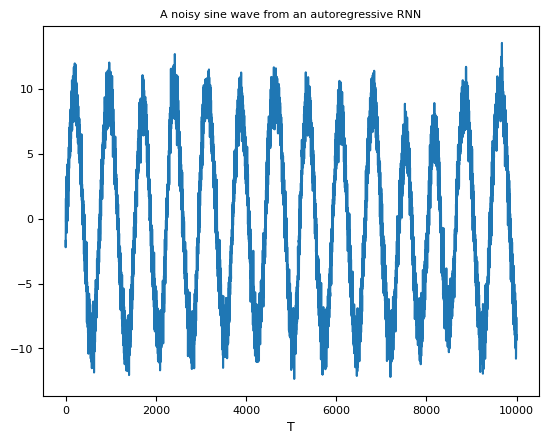

In [ ]:
from elk.models.flow import load_flow
from elk.models.model_utils import sample_AR_many_layers
model = load_flow("experiments/elk_exps_figs_4_7_8/argru_sine_wave_L=10000.eqx")
seed = 0
N_LAYERS = model.conditioners[0].seq_model.n_layers
P = model.conditioners[0].seq_model.ssm.P  # state size for AR GRU
H = model.conditioners[0].seq_model.ssm.H  # state size for input and output
DIM = N_LAYERS * P + 1
T = 10_000
max_iter = T

# seed specific
key = jr.split(jr.PRNGKey(seed), 1)[0]

# jit everything ahead of time
xs_AR_star, *_, noises, init_state = sample_AR_many_layers(
    model, T, key=key, dtype=jnp.float32
)
plt.plot(xs_AR_star.flatten())
plt.xlabel("T")
plt.title("A noisy sine wave from an autoregressive RNN")

Here are the intermediate traces of DEER and quasi-DEER. Notice how they are literally going "off-the-charts."

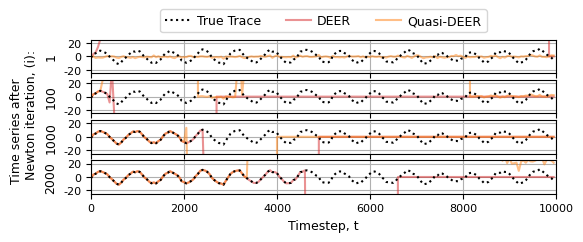

In [ ]:
from elk.utils.elk_utils import make_unpacking_tuple, packed_single_step, pack_state
unpacking_tuple = make_unpacking_tuple(model)
initial_packed_state = pack_state(init_state)
states_guess = jnp.zeros((T - 1, DIM))
drivers = noises

def fxn_for_deer(state, driver, params):
    return packed_single_step(model, unpacking_tuple, state, driver)

# Running DEER and quasi-DEER

deer_output = seq1d(fxn_for_deer, initial_packed_state,drivers[1:],None, max_iter=max_iter,full_trace=True)[0]
deer_output = jax.vmap( lambda seq: jnp.concatenate((initial_packed_state.reshape(1, -1), seq), axis=0))(deer_output)

qdeer_output = seq1d(fxn_for_deer, initial_packed_state,drivers[1:],None, max_iter=max_iter,quasi=True, qmem_efficient=False, full_trace=True)[0]
qdeer_output = jax.vmap( lambda seq: jnp.concatenate((initial_packed_state.reshape(1, -1), seq), axis=0))(qdeer_output)


# Plotting code

time_steps = 10_000
MAX_X = 10_000
MAX_Y = 25
SUBSAMPLE = 50
ITERS = [1, 100, 1000, 2000]

# Set up the axes.
fig, axes = plt.subplots(
    len(ITERS), 1, figsize=(6, 2), squeeze=True, sharex=True, sharey=True
)

# Iterate over the iters and plot.
for ax, n in zip(axes, ITERS):

    # Plot the true trace.
    ax.plot(
        np.arange(time_steps)[::SUBSAMPLE],
        xs_AR_star[:time_steps][::SUBSAMPLE],
        label="True Trace",
        c="k",
        linestyle=":",
        zorder=np.inf,
    )

    # Plot the four methods.
    ax.plot(
        np.arange(time_steps)[::SUBSAMPLE],
        deer_output[n, :time_steps, 0][::SUBSAMPLE],
        label=labs[1],
        c=cols[labs[1]],
        alpha=0.5,
    )
    ax.plot(
        np.arange(time_steps)[::SUBSAMPLE],
        qdeer_output[n, :time_steps, 0][::SUBSAMPLE],
        label=labs[2],
        c=cols[labs[2]],
        alpha=0.5,
    )

    ax.set_xlim(0, MAX_X)
    ax.set_ylim(-MAX_Y, MAX_Y)
    ax.grid(True)
    ax.set_yticklabels(ax.get_yticklabels())
    ax.set_yticks(
        [-20, 0, 20],
        [-20, 0, 20],
    )
    ax.set_ylabel(f"{n}")

# Set the bottom axis label.
axes[-1].set_xlabel("Timestep, t")

# Set the supylabel for the yaxes.
fig.supylabel("Time series after \n Newton iteration, (i):", x=-0.01, fontsize=MEDIUM_SIZE)

# Place the legend.
axes[0].legend(
    loc="upper center", ncol=5, handletextpad=0.5, bbox_to_anchor=(0.5, 2.1)
)

Newton's method can often be unstable, and so there exist many techniques in the literature to stabilize it. One of the most powerful techniques is to use a "trust region," which restricts the Newton update to lie in an $\ell_2$ ball. This approach is known as the Levenberg-Marquardt algorithm, and, very beautifully, it is equivalent to Kalman smoothing! This equivalence to Kalman smoothing is important because, just as linear recursions can be parallelized over the sequence length, so can Kalman smoothing.

These ingredients give rise to **ELK**: **E**valuating **L**evenberg-Marquardt with **K**alman, the next member of the ungulate family. We prove in our paper that ELK is attenuating the eigenvalues of the linearized dynamics of DEER. The amount of attentuation is governed by the strength of our regularization parameter. In our codebase, this regularization is controlled by `sigmasq`, where `sigmasq=0` means extremely strong regularization (trust region has radius zero), while as `sigmasq` goes to infinity, we approach DEER as a limiting case of ELK. In the notation of our paper, $\lambda = 1 / \sigma^2$.

Just as taking the diagonal of the dynamics of DEER gave rise to scalable quasi-DEER, so to we can apply the same regularization to quasi-DEER to achieve stable and scalable **quasi-ELK**.

You can use ELK from our codebase with `from elk.algs.elk import elk_alg`, and quasi-ELK can be turned on by using the flag `quasi=True`.

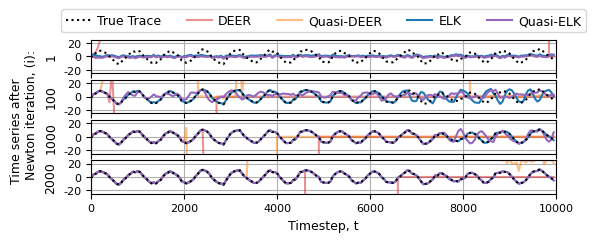

In [ ]:
from elk.algs.elk import elk_alg
fxn_for_elk = partial(packed_single_step, model, unpacking_tuple)
elk_sigmasq = 1e6
qelk_sigmasq = 1e2

# evaluate elk and quasi-ELK
elk_output = elk_alg(fxn_for_elk, initial_packed_state,states_guess,drivers[1:],sigmasq=elk_sigmasq,num_iters=max_iter)
qelk_output = elk_alg(fxn_for_elk, initial_packed_state,states_guess,drivers[1:],sigmasq=qelk_sigmasq,num_iters=max_iter, quasi=True)

# plotting code

# Plot the raw sine waves.
time_steps = 10_000
MAX_X = 10_000
MAX_Y = 25
SUBSAMPLE = 50
ITERS = [1, 100, 1000, 2000]

# Set up the axes.
fig, axes = plt.subplots(
    len(ITERS), 1, figsize=(6, 2), squeeze=True, sharex=True, sharey=True
)

# Iterate over the iters and plot.
for ax, n in zip(axes, ITERS):

    # Plot the true trace.
    ax.plot(
        np.arange(time_steps)[::SUBSAMPLE],
        xs_AR_star[:time_steps][::SUBSAMPLE],
        label="True Trace",
        c="k",
        linestyle=":",
        zorder=np.inf,
    )

    # Plot the four methods.
    ax.plot(
        np.arange(time_steps)[::SUBSAMPLE],
        deer_output[n, :time_steps, 0][::SUBSAMPLE],
        label=labs[1],
        c=cols[labs[1]],
        alpha=0.5,
    )
    ax.plot(
        np.arange(time_steps)[::SUBSAMPLE],
        qdeer_output[n, :time_steps, 0][::SUBSAMPLE],
        label=labs[2],
        c=cols[labs[2]],
        alpha=0.5,
    )
    ax.plot(
        np.arange(time_steps)[::SUBSAMPLE],
        elk_output[n, :time_steps, 0][::SUBSAMPLE],
        label=labs[3],
        c=cols[labs[3]],
    )
    ax.plot(
        np.arange(time_steps)[::SUBSAMPLE],
        qelk_output[n, :time_steps, 0][::SUBSAMPLE],
        label=labs[4],
        c=cols[labs[4]],
    )

    ax.set_xlim(0, MAX_X)
    ax.set_ylim(-MAX_Y, MAX_Y)
    ax.grid(True)
    ax.set_yticklabels(ax.get_yticklabels())
    ax.set_yticks(
        [-20, 0, 20],
        [-20, 0, 20],
    )
    ax.set_ylabel(f"{n}")

# Set the bottom axis label.
axes[-1].set_xlabel("Timestep, t")

# Set the supylabel for the yaxes.
fig.supylabel(
    "Time series after \n Newton iteration, (i):", x=-0.01, fontsize=MEDIUM_SIZE
)

# Place the legend.
axes[0].legend(
    loc="upper center", ncol=5, handletextpad=0.5, bbox_to_anchor=(0.5, 2.1)
)


Notice how the ELK intermediate trajectories (blue) and quasi-ELK intermediate trajectories (purple) are much more stable and converge faster than unregularized DEER!

# Conclusion

For most applications involving parallelizing RNNs, **quasi-DEER** is a great choice because of its scalability.

However, depending on the problem (sequence length, dimensions, dynamics), and the hardware you have available, either sequential or the parallel ungulates (DEER, quasi-DEER, ELK, and quasi-ELK) could be fastest (and remember to check different regularization strengths for `sigmasq`, in the paper we sweep over them on a log scale). We are still working on understanding the different regimes where each algorithm is best, as well as the effect of different hardware and software on performance. We will continue to to make changes to [elk-dev](https://github.com/lindermanlab/elk-dev), and so PRs are very welcome!

Thanks for reading---and go forth parallelizing RNNs!